### Online Transaction History

Online trasacation data is more rich and relevant than in-store purchase data as many transaction are occuring online in response to COViD-19. We will perform and EDA and predict non contractual churn risk of customers.

In [132]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import lifetimes
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

from lifetimes.plotting import plot_cumulative_transactions,plot_incremental_transactions

In [133]:
# Bring in data

trnsc = pd.read_csv('transactions_export_1.csv')
orders = pd.read_csv('orders_export_1.csv')


/home/daniel/anaconda3/envs/insight/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (53,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [134]:
trnsc.head()

,Order,Name,Kind,Gateway,Created At,Status,Amount,Currency,Card Type
0,2518084223139,#0620-13227,sale,paypal,2020-06-12 12:20:47 -0700,success,36.80,USD,NaN
1,2518080782499,#0620-13226,sale,authorize_net,2020-06-12 12:18:25 -0700,success,89.95,USD,visa
2,2518031433891,#0620-13225,sale,authorize_net,2020-06-12 11:51:35 -0700,success,10.50,USD,visa
3,2517958131875,#0620-13224,sale,authorize_net,2020-06-12 11:10:33 -0700,success,72.90,USD,visa
4,2517866184867,#0620-13223,sale,authorize_net,2020-06-12 10:31:55 -0700,success,119.95,USD,master


In [135]:
orders.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#0620-13230,penny.com12@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# Create a unique_id for each customer. Surprisingly it is not in the data.

Email = list(orders.Email.unique())
orders['customer_unique_id'] = orders.Email.apply(lambda x: Email.index(x))

1.1  Building out the dataset

The model only requires a few variables, Let's do some feature engineering and focus only on what we really need for the RFM analysis.

In [137]:
# Distribution of purchases made by customers

orders.groupby('customer_unique_id').size().value_counts()

1      8607
2      1257
3       341
4       163
5        75
6        38
7        27
8        20
9        10
11        5
12        4
10        3
18        2
14        2
24        2
30        1
16        1
15        1
17        1
29        1
13        1
22        1
19        1
23        1
20        1
175       1
dtype: int64

In [138]:
# Order Id's have multiple entries. Keep the first line as that has price information associated with it.

orders.drop_duplicates('Name',keep='first',inplace=True)

In [139]:
orders.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,#0620-13228,hanksimon@hotmail.com,paid,2020-06-12 15:57:55 -0700,unfulfilled,NaN,no,USD,99.75,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [140]:
orders.groupby('customer_unique_id').size().value_counts()

1     9565
2      748
3      161
4       53
5       17
8        7
7        5
6        5
9        2
19       1
11       1
10       1
80       1
dtype: int64

In [141]:
orders_master = orders

In [143]:
orders_master.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,#0620-13228,hanksimon@hotmail.com,paid,2020-06-12 15:57:55 -0700,unfulfilled,NaN,no,USD,99.75,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [144]:
transaction_data= orders[['customer_unique_id','Total','Created at']]

In [145]:
transaction_data.columns = transaction_data.columns.str.replace(' ', '_')

In [146]:
list(transaction_data.columns) 

['customer_unique_id', 'Total', 'Created_at']

In [147]:
transaction_data.head()

,customer_unique_id,Total,Created_at
0,0,110.00,2020-06-13 10:31:06 -0700
1,1,10.00,2020-06-13 06:49:14 -0700
2,2,63.30,2020-06-12 16:47:56 -0700
4,3,36.95,2020-06-12 16:43:53 -0700
5,4,99.75,2020-06-12 15:57:54 -0700


In [148]:
pd.to_datetime(transaction_data.Created_at.apply(lambda x: x.split()[0]))

0       2020-06-13
1       2020-06-13
2       2020-06-12
4       2020-06-12
5       2020-06-12
           ...    
14457   2014-12-08
14458   2014-12-08
14459   2014-12-06
14460   2014-12-06
14461   2014-12-06
Name: Created_at, Length: 12100, dtype: datetime64[ns]

In [149]:
transaction_data.head()

,customer_unique_id,Total,Created_at
0,0,110.00,2020-06-13 10:31:06 -0700
1,1,10.00,2020-06-13 06:49:14 -0700
2,2,63.30,2020-06-12 16:47:56 -0700
4,3,36.95,2020-06-12 16:43:53 -0700
5,4,99.75,2020-06-12 15:57:54 -0700


In [150]:
transaction_data['Created_at']= pd.to_datetime(transaction_data['Created_at'], errors='coerce', utc = True).dt.date

In [151]:
transaction_data.head()

,customer_unique_id,Total,Created_at
0,0,110.00,2020-06-13
1,1,10.00,2020-06-13
2,2,63.30,2020-06-12
4,3,36.95,2020-06-12
5,4,99.75,2020-06-12


In [152]:
transaction_data['date'] = transaction_data['Created_at']
transaction_data['price'] = transaction_data['Total']
transaction_data.head()

,customer_unique_id,Total,Created_at,date,price
0,0,110.00,2020-06-13,2020-06-13,110.00
1,1,10.00,2020-06-13,2020-06-13,10.00
2,2,63.30,2020-06-12,2020-06-12,63.30
4,3,36.95,2020-06-12,2020-06-12,36.95
5,4,99.75,2020-06-12,2020-06-12,99.75


In [153]:
# Drop 'Paid_at'
transaction_data.drop(columns=['Created_at', 'Total'])


,customer_unique_id,date,price
0,0,2020-06-13,110.00
1,1,2020-06-13,10.00
2,2,2020-06-12,63.30
4,3,2020-06-12,36.95
5,4,2020-06-12,99.75
...,...,...,...
14457,10563,2014-12-08,229.90
14458,4729,2014-12-08,99.90
14459,10564,2014-12-07,79.95
14460,10565,2014-12-07,82.90


#### CLV Models

In [154]:
transaction_data.head()

,customer_unique_id,Total,Created_at,date,price
0,0,110.00,2020-06-13,2020-06-13,110.00
1,1,10.00,2020-06-13,2020-06-13,10.00
2,2,63.30,2020-06-12,2020-06-12,63.30
4,3,36.95,2020-06-12,2020-06-12,36.95
5,4,99.75,2020-06-12,2020-06-12,99.75


In [155]:
modeldata = summary_data_from_transaction_data(transaction_data, 'customer_unique_id', 'date', monetary_value_col='price', observation_period_end='2020-06-13')
modeldata.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [156]:
print(modeldata['frequency'].describe())

count    10567.000000
mean         0.131731
std          0.858679
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         70.000000
Name: frequency, dtype: float64


In [157]:
from lifetimes import BetaGeoFitter


bgf = BetaGeoFitter(penalizer_coef=0.0)

bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 10567 subjects, a: 1.89, alpha: 3.82, b: 0.83, r: 0.02>


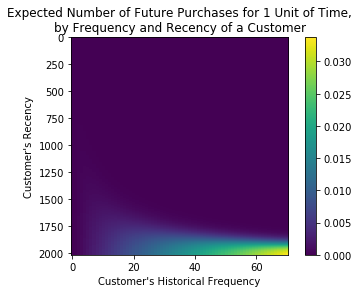

In [158]:
# create frequency recency matrix
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)
#plt.savefig('plot21.png', dpi=300, bbox_inches='tight')

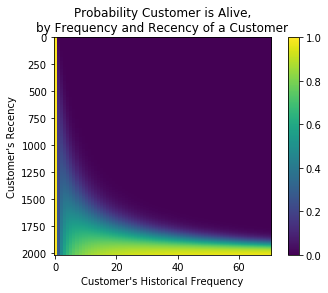

In [159]:
#Create probability alive matrix
from lifetimes.plotting import plot_probability_alive_matrix

#fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
#plt.savefig('plot22.png', dpi=300, bbox_inches='tight')

In [160]:
# Predict future transactions

#t = 183 # Equaivalent to 1 day - Parameterized for expected purchases in 6 month period
#modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])
#modeldata.sort_values(by='predicted_purchases').tail(5)

# May want to add columns according to customer tiers

In [161]:
#modeldata.sort_values(by='predicted_purchases').head(895)

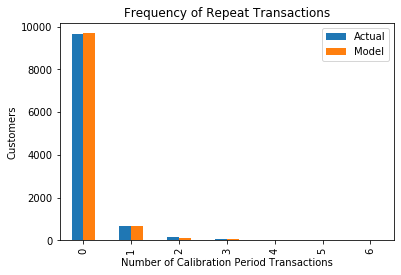

In [162]:
# Create Performance Tracking Plot

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)


In [163]:
transaction_data.head()

,customer_unique_id,Total,Created_at,date,price
0,0,110.00,2020-06-13,2020-06-13,110.00
1,1,10.00,2020-06-13,2020-06-13,10.00
2,2,63.30,2020-06-12,2020-06-12,63.30
4,3,36.95,2020-06-12,2020-06-12,36.95
5,4,99.75,2020-06-12,2020-06-12,99.75


In [164]:
# Get a look at start and end dates for period
transaction_data.sort_values(by='date', ascending=True)


,customer_unique_id,Total,Created_at,date,price
14461,10566,89.90,2014-12-06,2014-12-06,89.90
14460,10565,82.90,2014-12-07,2014-12-07,82.90
14459,10564,79.95,2014-12-07,2014-12-07,79.95
14452,10559,139.95,2014-12-08,2014-12-08,139.95
14453,10560,139.80,2014-12-08,2014-12-08,139.80
...,...,...,...,...,...
12,11,429.80,2020-06-12,2020-06-12,429.80
18,12,60.80,2020-06-12,2020-06-12,60.80
8,7,10.50,2020-06-12,2020-06-12,10.50
1,1,10.00,2020-06-13,2020-06-13,10.00


Period of interest at the upper bound is 2020-06-13 at the lower bound it's 2014-12-06. Break the observation window in half.

In [165]:
# Model Caliboration

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',
                                        calibration_period_end='2018-06-12',
                                        observation_period_end='2020-06-12')
print(summary_cal_holdout.head())

                    frequency_cal  recency_cal   T_cal  frequency_holdout  \
customer_unique_id                                                          
86                            0.0          0.0  1169.0                1.0   
265                           2.0        272.0   292.0                1.0   
268                           3.0        726.0   780.0                1.0   
272                           0.0          0.0   843.0                1.0   
323                           2.0          6.0  1094.0                8.0   

                    duration_holdout  
customer_unique_id                    
86                               731  
265                              731  
268                              731  
272                              731  
323                              731  


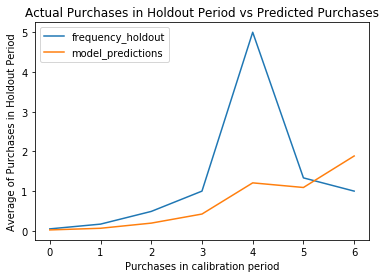

In [166]:
# Plot
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
#plt.savefig('plot23.png', dpi=300, bbox_inches='tight')

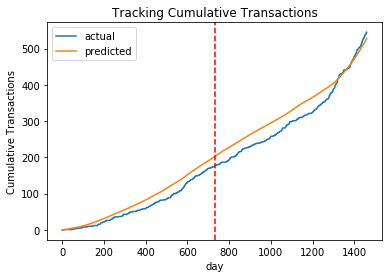

In [167]:
# Plot cummulative transacstions

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 1460, 730);
#plt.savefig('plot4.png', dpi=300, bbox_inches='tight')

In [168]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_unique_id,,,,,
86,0.0,0.0,1169.0,1.0,731
265,2.0,272.0,292.0,1.0,731
268,3.0,726.0,780.0,1.0,731
272,0.0,0.0,843.0,1.0,731
323,2.0,6.0,1094.0,8.0,731


Making churn predictions

In [169]:
chrndf = modeldata
chrndf.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


frequency excludes the customer's first purchase because that is considered the day the customer is born. Afterwards, you can begin to question whether or not that customer is alive

count    10567.000000
mean         0.131731
std          0.858679
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         70.000000
Name: frequency, dtype: float64
0.9131257689031892


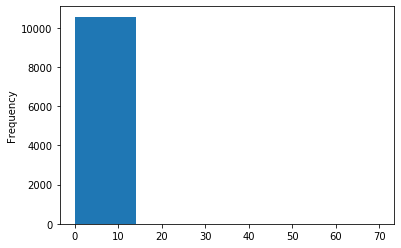

In [170]:
#chrndf[chrndf['frequency']>0].head()

## Insert something in here about customer purchase frequency

chrndf['frequency'].plot(kind='hist', bins=5)
print(chrndf['frequency'].describe())
print(sum(chrndf['frequency'] == 0)/float(len(chrndf)))

In [171]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(chrndf['frequency'], chrndf['recency'], chrndf['T']);

In [172]:
# Cummulative transaction

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2018-06-12', observation_period_end='2020-06-12' )

In [173]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3013 subjects, a: 2.41, alpha: 3.45, b: 0.97, r: 0.02>

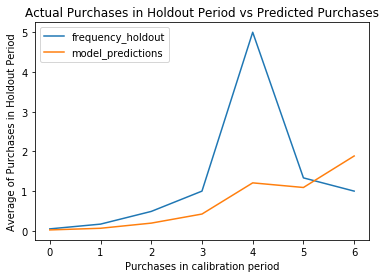

In [174]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

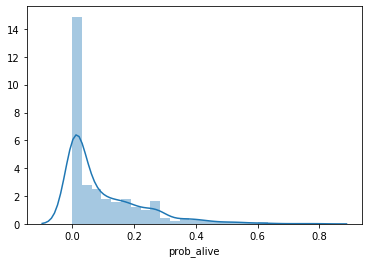

In [175]:


df = chrndf[chrndf['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

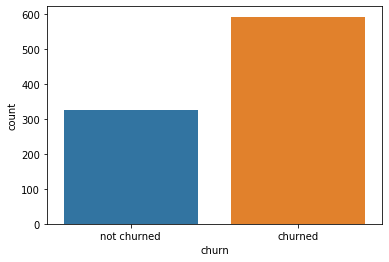

In [176]:
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);

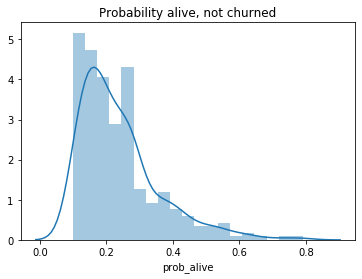

In [177]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

In [178]:
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

churned        593
not churned    170
high risk      155
Name: churn, dtype: int64

In [179]:
df.head()

,frequency,recency,T,monetary_value,prob_alive,churn
customer_unique_id,,,,,,
6,1.0,6.0,7.0,89.95,0.266403,not churned
14,1.0,23.0,25.0,86.13,0.271954,not churned
17,1.0,3.0,5.0,456.45,0.234033,not churned
23,1.0,56.0,58.0,229.95,0.280060,not churned
62,1.0,10.0,14.0,119.95,0.235812,not churned


In [180]:
chrncnt = {'Customer_Status':['Churned','Not Churned','High Risk'],
          'Count':[593,170,155]}


#cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
 #       'Price': [22000,25000,27000,35000]
  #      }

chrncntdf = pd.DataFrame(chrncnt, columns = ['Customer_Status','Count'], index=['Category_1','Category_2','Category_3'])

In [181]:
print(chrncntdf)

           Customer_Status  Count
Category_1         Churned    593
Category_2     Not Churned    170
Category_3       High Risk    155


In [182]:
df.head()

,frequency,recency,T,monetary_value,prob_alive,churn
customer_unique_id,,,,,,
6,1.0,6.0,7.0,89.95,0.266403,not churned
14,1.0,23.0,25.0,86.13,0.271954,not churned
17,1.0,3.0,5.0,456.45,0.234033,not churned
23,1.0,56.0,58.0,229.95,0.280060,not churned
62,1.0,10.0,14.0,119.95,0.235812,not churned


In [183]:
mrkt_df = df.drop(columns=['frequency','recency','T','monetary_value','prob_alive'])

In [184]:
mrkt_df.head()

,churn
customer_unique_id,
6,not churned
14,not churned
17,not churned
23,not churned
62,not churned


### Join Tables and export .csv for marketing

So the categories for churn have been calculated based on the above modeling exercise. The data frame has been trimmed down to just the Customer ID, merge that to the original dataframe and do some parsing to make it legible for Josh.

The original raw dataset of interest that has had duplicates removed and a `customer_unique_id` calculated is `orders_master`.

In [186]:
orders_master.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,#0620-13228,hanksimon@hotmail.com,paid,2020-06-12 15:57:55 -0700,unfulfilled,NaN,no,USD,99.75,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [190]:
mrkt_df.head()

,churn
customer_unique_id,
6,not churned
14,not churned
17,not churned
23,not churned
62,not churned


In [191]:
len(mrkt_df)

918

#### Merge `mrkt_df` and `orders_master`

Merge these two and pair down the relevant data. Then export as a .csv

In [187]:
market_emailist = pd.merge(orders_master, mrkt_df, on='customer_unique_id')

In [188]:
market_emailist.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id,churn
0,#0620-13226,annejcourt@sbcglobal.net,paid,2020-06-12 12:18:29 -0700,unfulfilled,NaN,no,USD,89.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,not churned
1,#0620-13125,annejcourt@sbcglobal.net,paid,2020-06-06 06:19:14 -0700,fulfilled,2020-06-08 11:30:21 -0700,no,USD,89.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,not churned
2,#0620-13218,glendathree@gmail.com,paid,2020-06-11 13:24:44 -0700,fulfilled,2020-06-12 10:43:11 -0700,yes,USD,86.13,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,not churned
3,#0520-12718,glendathree@gmail.com,paid,2020-05-19 10:51:13 -0700,fulfilled,2020-05-20 09:10:41 -0700,yes,USD,197.96,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,not churned
4,#0620-13215,facialimage@gmail.com,paid,2020-06-11 11:59:10 -0700,fulfilled,2020-06-12 11:01:11 -0700,no,USD,456.45,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,not churned


Now subset down to columns of interest: Name, Email, Accepts Marketing, customer_unique_id, churn

In [189]:
len(market_emailist)

2364

Duplicates in customer unique ID

In [192]:
orders_master.groupby('customer_unique_id').size().value_counts()

1     9565
2      748
3      161
4       53
5       17
8        7
7        5
6        5
9        2
19       1
11       1
10       1
80       1
dtype: int64

# I think there is an issue with duplicate orders. Commit then explore dropping duplicates and rerunning analysis.